# Double-Layer Shallow Dome

This is adapted from [an example created by Amir Hossein Namadchi](https://github.com/AmirHosseinNamadchi/OpenSeesPy-Examples/blob/master/Double-Layer%20Shallow%20Dome.ipynb).

This is an OpenSeesPy simulation of one of the numerical examples in our previously [published paper](https://ascelibrary.org/doi/abs/10.1061/%28ASCE%29EM.1943-7889.0001329). The Core was purely written in *Mathematica*. This is my attempt to perform the analysis again via Opensees Core, to see if I can get the similar results. In the paper, we used *Total Lagrangian* framework to model the structure. Unfortunately, OpenSees does not include this framework, so, alternatively, I will use Corotational truss element.


In [1]:
import numpy as np
import openseespy.opensees as ops
import matplotlib.pyplot as plt
import opstool as opst
import opstool.vis.plotly as opsvis
# import opstool.vis.pyvista as opsvis

Below, the base units are defined as python variables:

In [2]:
## Units
m = 1  # Meters
KN = 1  # KiloNewtons
s = 1  # Seconds

![image_2](https://s2.loli.net/2025/05/01/oI8PQYRZcVOGNTy.png)

### Model Defintion
The coordinates information for each node are stored `node_coords`. Each row represent a node with the corresponding coordinates. Elements configuration are also described in `connectivity`, each row representing an element with its node IDs. Elements cross-sectional areas are stored in `area_list`. This appraoch, offers a more pythonic and flexible code when building the model. Since this is a relatively large model, some data will be read from external `.txt` files to keep the code cleaner.

In [3]:
# Node Coordinates Matrix (size : nn x 3)
node_coords = np.loadtxt("nodes.txt", dtype=np.float64) * m

# Element Connectivity Matrix (size: nel x 2)
connectivity = np.loadtxt("connectivity.txt", dtype=np.int64).tolist()

# Loaded Nodes
loaded_nodes = np.loadtxt("loaded_nodes.txt", dtype=np.int64).tolist()

# Get Number of total Nodes
nn = len(node_coords)
# Get Number of total Elements
nel = len(connectivity)

# Cross-sectional area list (size: nel)
area_list = np.ones(nel) * (0.001) * (m**2)

# Modulus of Elasticity list (size: nel)
E_list = np.ones(nel) * (2.0 * 10**8) * (KN / m**2)

# Mass Density
rho = 7.850 * ((KN * s**2) / (m**4))

# Boundary Conditions (size: fixed_nodes x 4)
B_C = np.column_stack((np.arange(1, 31), np.ones((30, 3), dtype=np.int64))).tolist()

### Model Construction
I use <i>list comprehension</i> to add nodes,elements and other objects to the domain. 

In [4]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 3)

# Adding nodes to the model object using list comprehensions
[ops.node(n + 1, *node_coords[n]) for n in range(nn)]
# Applying BC
[ops.fix(B_C[n][0], *B_C[n][1:]) for n in range(len(B_C))]
# Set Material
ops.uniaxialMaterial("Elastic", 1, E_list[0])

# Adding Elements
[
    ops.element(
        "corotTruss",
        e + 1,
        *connectivity[e],
        area_list[e],
        1,
        "-rho",
        rho * area_list[e],
        "-cMass",
        1,
    )
    for e in range(nel)
];

### Draw model

In [5]:
opsvis.set_plot_colors(truss="blue")
fig = opsvis.plot_model()
fig.show()

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

In [6]:
fig.write_html("images/dome_model.html", full_html=False, include_plotlyjs="cdn")

* ### Eigenvalue Analysis
Let's get the first 6 periods of the structure to see if they coincide with the ones in paper.

In [7]:
opst.post.save_eigen_data(odb_tag="eigen", mode_tag=6)
fig = opsvis.plot_eigen(odb_tag="eigen", mode_tags=6, subplots=True)
fig.show()

Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Eigen data has been saved to _OPSTOOL_ODB/EigenData-eigen.nc!

OPSTOOL ::  Loading eigen data from _OPSTOOL_ODB/EigenData-eigen.nc ...

In [8]:
fig.write_html("images/dome_eigen.html", full_html=False, include_plotlyjs="cdn")

In [9]:
model_props, eigen_vectors = opst.post.get_eigen_data(odb_tag="eigen")

model_props_df = model_props.to_pandas()
model_props_df.head()

OPSTOOL ::  Loading eigen data from _OPSTOOL_ODB/EigenData-eigen.nc ...

Properties,eigenLambda,eigenOmega,eigenFrequency,eigenPeriod,partiFactorMX,partiFactorMY,partiFactorRMZ,partiFactorMZ,partiFactorRMX,partiFactorRMY,...,partiMassRatiosRMZ,partiMassRatiosMZ,partiMassRatiosRMX,partiMassRatiosRMY,partiMassRatiosCumuMX,partiMassRatiosCumuMY,partiMassRatiosCumuRMZ,partiMassRatiosCumuMZ,partiMassRatiosCumuRMX,partiMassRatiosCumuRMY
modeTags,,,,,,,,,,,,,,,,,,,,,
1,7638.300855,87.397373,13.909724,0.071892,2.499959e-14,1.090711e-13,-1.496931e-15,-3.976249e+00,1.681521e-12,-3.821370e-13,...,1.978638e-31,8.812159e+01,4.781709e-25,2.469538e-26,3.483380e-27,6.630625e-26,1.978638e-31,88.121593,4.781709e-25,2.469538e-26
2,8513.716124,92.269801,14.685195,0.068096,-1.086439e-08,1.154027e+00,-5.840163e-15,3.907547e-13,1.729894e+01,1.628580e-07,...,3.011709e-30,8.510275e-25,5.060779e+01,4.485341e-15,6.578786e-16,7.422784e+00,3.209573e-30,88.121593,5.060779e+01,4.485341e-15
3,8513.720290,92.269823,14.685198,0.068096,1.154026e+00,1.086440e-08,3.007549e-14,8.953602e-14,1.628581e-07,-1.729893e+01,...,7.987087e-29,4.468180e-26,4.485356e-15,5.060763e+01,7.422775e+00,7.422784e+00,8.308044e-29,88.121593,5.060779e+01,5.060763e+01
4,18270.645118,135.168950,21.512807,0.046484,-3.122448e-15,-1.353991e-14,-8.613185e-15,-9.731419e-07,-9.334219e-14,-4.695962e-14,...,6.550742e-30,5.278220e-12,1.473446e-27,3.729294e-28,7.422775e+00,7.422784e+00,8.963118e-29,88.121593,5.060779e+01,5.060763e+01
5,18270.691855,135.169123,21.512834,0.046484,7.892287e-15,-6.400588e-15,-2.009890e-05,-1.591381e-14,7.588860e-15,5.677972e-14,...,3.567035e-11,1.411509e-27,9.739381e-30,5.452103e-28,7.422775e+00,7.422784e+00,3.567035e-11,88.121593,5.060779e+01,5.060763e+01


In [10]:
print(f"*** Eigen periods:\n {model_props_df['eigenPeriod']}")

*** Eigen periods:
 modeTags
1    0.071892
2    0.068096
3    0.068096
4    0.046484
5    0.046484
6    0.031170
Name: eigenPeriod, dtype: float64


### Dynamic Analysis

Great accordance is obtained in eigenvalue analysis. Now, let's do `wipeAnalysis()` and perform dynamic analysis. The Newmark time integration algorithm with $\gamma=0.5$ and $\beta=0.25$ (Constant Average Acceleration Algorithm) is used. Harmonic loads are applied vertically on the `loaded_nodes` nodes.

In [11]:
ops.wipeAnalysis()


# define load function
def P(t):
    """Load function"""
    return 250 * np.sin(250 * t)


# Dynamic Analysis Parameters
dt = 0.00025
time = 0.2
time_domain = np.arange(0, time, dt)

# Adding loads to the domain beautifully
ops.timeSeries(
    "Path",
    1,
    "-dt",
    dt,
    "-values",
    *np.vectorize(P)(time_domain),
    "-time",
    *time_domain,
)
ops.pattern("Plain", 1, 1)
[ops.load(n, *[0, 0, -1]) for n in loaded_nodes]
# Analysis
ops.constraints("Plain")
ops.numberer("Plain")
ops.system("ProfileSPD")
ops.test("NormUnbalance", 0.0000001, 100)
ops.algorithm("ModifiedNewton")
ops.integrator("Newmark", 0.5, 0.25)
ops.analysis("Transient")

#### Save the results

In [12]:
ODB = opst.post.CreateODB(odb_tag=1)

for i in range(len(time_domain)):
    is_done = ops.analyze(1, dt)
    if is_done != 0:
        print("Failed to Converge!")
        break
    ODB.fetch_response_step()
ODB.save_response(zlib=True)  # for compressing the file

OPSTOOL ::  All responses data with _odb_tag = 1 saved in _OPSTOOL_ODB/RespStepData-1.nc!

### Visualization
Below, the time history of the vertical displacement of the apex is plotted.

#### Retrieving Nodal Response Results

In [13]:
node_resp = opst.post.get_nodal_responses(odb_tag=1)
print(node_resp.head())

OPSTOOL ::  Loading all response data from _OPSTOOL_ODB/RespStepData-1.nc ...

<xarray.Dataset> Size: 6kB
Dimensions:             (time: 5, nodeTags: 5, DOFs: 5)
Coordinates:
  * nodeTags            (nodeTags) int32 20B 1 2 3 4 5
  * DOFs                (DOFs) <U2 40B 'UX' 'UY' 'UZ' 'RX' 'RY'
  * time                (time) float64 40B 0.0 0.00025 0.0005 0.00075 0.001
Data variables:
    disp                (time, nodeTags, DOFs) float64 1kB 0.0 0.0 ... 0.0 0.0
    vel                 (time, nodeTags, DOFs) float64 1kB 0.0 0.0 ... 0.0 0.0
    accel               (time, nodeTags, DOFs) float64 1kB 0.0 0.0 ... 0.0 0.0
    reaction            (time, nodeTags, DOFs) float64 1kB 0.0 0.0 ... 0.0 0.0
    reactionIncInertia  (time, nodeTags, DOFs) float64 1kB 0.0 0.0 ... 0.0 0.0
    rayleighForces      (time, nodeTags, DOFs) float64 1kB 0.0 0.0 ... 0.0 0.0
    pressure            (time, nodeTags) float32 100B 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    UX:       Displacement in X direction
    UY:       Displacement in Y direction
    UZ:       Displacement in Z direction
   

We select the target data through the indexing method provided by [xarray](https://docs.xarray.dev/en/stable/user-guide/indexing.html)

In [14]:
time = node_resp["time"].values
disp = node_resp["disp"].sel(nodeTags=362, DOFs="UZ")

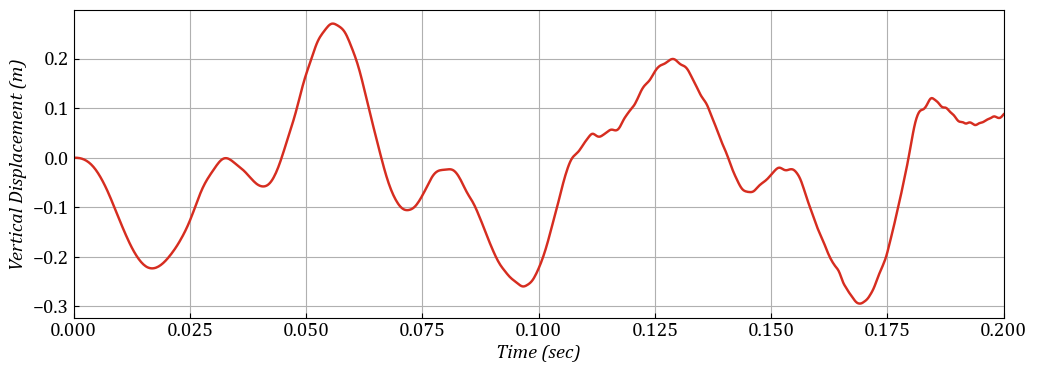

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(time, disp, color="#d62d20", linewidth=1.75)
plt.ylabel(
    "Vertical Displacement (m)",
    {"fontname": "Cambria", "fontstyle": "italic", "size": 14},
)
plt.xlabel("Time (sec)", {"fontname": "Cambria", "fontstyle": "italic", "size": 14})
plt.xlim([0.0, max(time)])
plt.grid()
plt.yticks(fontname="Cambria", fontsize=14)
plt.xticks(fontname="Cambria", fontsize=14)
plt.show()

#### Retrieving Element Response Results

In [16]:
ele_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Truss")
print(ele_resp.head())

OPSTOOL ::  Loading Truss response data from _OPSTOOL_ODB/RespStepData-1.nc ...

<xarray.Dataset> Size: 760B
Dimensions:     (time: 5, eleTags: 5)
Coordinates:
  * eleTags     (eleTags) int32 20B 1 2 3 4 5
  * time        (time) float64 40B 0.0 0.00025 0.0005 0.00075 0.001
Data variables:
    axialForce  (time, eleTags) float64 200B 0.0 0.0 0.0 ... 0.2356 0.2356
    axialDefo   (time, eleTags) float64 200B 0.0 0.0 0.0 ... 2.955e-06 2.955e-06
    Stress      (time, eleTags) float64 200B 0.0 0.0 0.0 ... 235.6 235.6 235.6
    Strain      (time, eleTags) float32 100B 0.0 0.0 0.0 ... 1.178e-06 1.178e-06


In [17]:
force = ele_resp["axialForce"].sel(eleTags=10)
defo = ele_resp["axialDefo"].sel(eleTags=10)

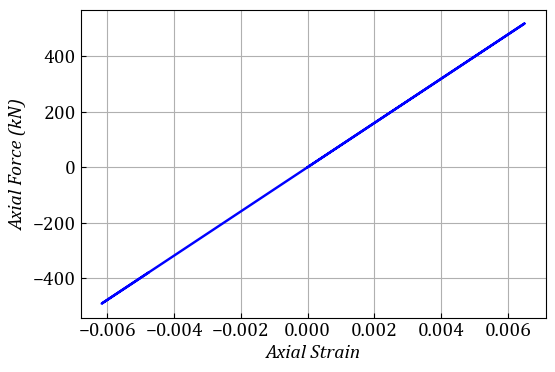

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(defo, force, color="blue", linewidth=1.75)
plt.ylabel(
    "Axial Force (kN)",
    {"fontname": "Cambria", "fontstyle": "italic", "size": 14},
)
plt.xlabel("Axial Strain", {"fontname": "Cambria", "fontstyle": "italic", "size": 14})
plt.grid()
plt.yticks(fontname="Cambria", fontsize=14)
plt.xticks(fontname="Cambria", fontsize=14)
plt.show()

### Closure
Very good agreements with the paper are obtained.
<blockquote>Namadchi, Amir Hossein, Farhang Fattahi, and Javad Alamatian. "Semiexplicit Unconditionally Stable Time Integration for Dynamic Analysis Based on Composite Scheme." Journal of Engineering Mechanics 143, no. 10 (2017): 04017119.</blockquote>
